In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
df = pd.read_csv('data/purchase/purchase-train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 602 entries, ID to class
dtypes: int64(602)
memory usage: 45.9 MB


In [3]:
df = df.loc[:, df.columns != 'ID']
df.head()

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,class
0,0,0,0,1,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,86
1,0,0,0,1,1,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,81
2,0,1,1,1,1,1,1,0,0,1,...,1,0,1,0,1,0,0,0,0,3
3,0,1,0,1,1,1,1,0,0,1,...,0,1,0,0,1,0,0,0,0,19
4,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,76


In [4]:
df.isnull().sum().sum()

0

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'class'], df['class'], test_size=0.3, random_state=42)

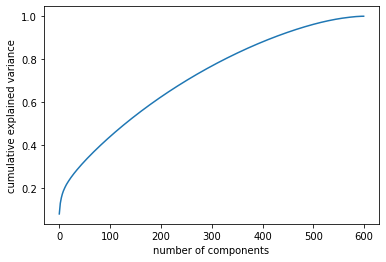

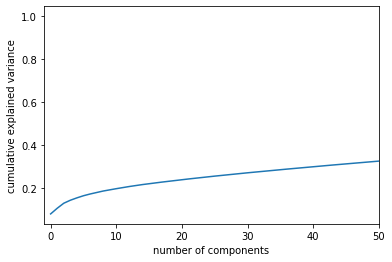

In [6]:
## dimensional reduction
f1 = plt.figure()
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
#plt.clf()

f2 = plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim([-1,50])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

plt.show()

pipeline = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('clf', PCA(n_components=10)) #step2 - classifier
])

X_train_reduced = pd.DataFrame(pipeline.fit_transform(X_train))

X_test_reduced = pd.DataFrame(pipeline.transform(X_test))

Accuracy: 0.26166666666666666
F1 Score: 0.26166666666666666
0.26 accuracy with a standard deviation of 0.02
-------------
fit_time  mean  3.4109345436096192
fit_time  std  0.15112590097256087
score_time  mean  0.11589970588684081
score_time  std  0.014609001911160407
test_score  mean  0.2571428571428572
test_score  std  0.01559042092086663
-------------
10
40
70
100
130
160
190
220
250
280
310
340
370
400
430
460
490


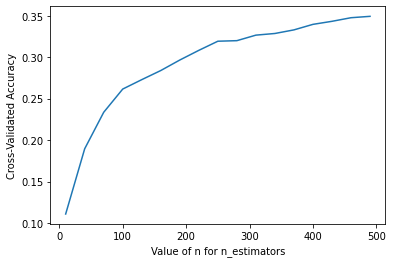

-------------bestN--------
0.34933333333333333
490


In [7]:
# random forest classifier - Long running time

#not scaled
forest = RandomForestClassifier(n_estimators=100, random_state=100)
forest.fit(X_train,y_train)
predictions = forest.predict(X_test)
print("Accuracy:",accuracy_score(y_test, predictions))
print("F1 Score:",metrics.f1_score(y_test, predictions,average='micro'))


#CV not scaled
scores = cross_val_score(forest, X_train, y_train, cv=5, scoring='accuracy')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print('-------------')
#CV scaled
pipeline = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('clf', RandomForestClassifier(n_estimators=100, random_state=100)) #step2 - classifier
])
scores = cross_validate(pipeline, X_train, y_train)
for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())
            
## Hyper parameter tuning
print('-------------')
n_range = range(10,500,30)
n_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for n in n_range:
    print(str(n))
    pipeline.set_params(clf__n_estimators=n)
    pipeline.fit(X_train,y_train)
    predictions = pipeline.predict(X_test)
    score = accuracy_score(y_test, predictions)
    n_scores.append(score)
# plot to see clearly
plt.plot(n_range, n_scores)
plt.xlabel('Value of n for n_estimators')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

print('-------------bestN--------')

max_acc = max(n_scores)
at_n = n_range[n_scores.index(max_acc)]
print(max_acc)
print(at_n)



In [8]:
## neural network MLPClassifier

#not scaled
mlp = MLPClassifier(hidden_layer_sizes=(50,10,5),random_state=1, max_iter=300,activation = 'relu',solver = 'adam')
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_test)
print("Accuracy:",accuracy_score(y_test, predictions))
print("F1 Score:",metrics.f1_score(y_test, predictions,average='micro'))

#scaled
pipeline.set_params(clf = mlp)
pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_test)
print("Accuracy:",accuracy_score(y_test, predictions))

#reduced scaled frame
print('------------- reduced frame ------')
pipeline.fit(X_train_reduced,y_train)
scores = cross_validate(pipeline, X_train_reduced, y_train)
for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())
            
            
# gridSearch on reduced frame
params = [{'clf__hidden_layer_sizes': [(50,10,5), (100,50,20)],
         'clf__max_iter': [300, 500, 1000]}]

gs_mlp = GridSearchCV(pipeline,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
gs_mlp.fit(X_train_reduced, y_train)

print(gs_mlp.best_params_)
print(gs_mlp.score(X_train_reduced, y_train))


Accuracy: 0.3446666666666667
F1 Score: 0.3446666666666667
Accuracy: 0.29433333333333334
------------- reduced frame ------


C:\Users\lukb9\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lukb9\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lukb9\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lukb9\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

fit_time  mean  8.252599382400513
fit_time  std  0.31011153531637486
score_time  mean  0.004303646087646484
score_time  std  0.0006006401315170512
test_score  mean  0.5784285714285715
test_score  std  0.015188610125716612


C:\Users\lukb9\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lukb9\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lukb9\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lukb9\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

{'clf__hidden_layer_sizes': (100, 50, 20), 'clf__max_iter': 300}
0.907


In [9]:
## linear SVC

#not scaled
clf = SVC(kernel='linear')
clf = clf.fit(X_train_reduced,y_train)
y_pred = clf.predict(X_test_reduced)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred,average='micro'))

#scaled
pipeline.set_params(clf = clf)
pipeline.fit(X_train_reduced,y_train)
y_pred = pipeline.predict(X_test_reduced)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred,average='micro'))

print('--------')
scores = cross_validate(pipeline, X_train_reduced, y_train)
for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())
print('--------')
# gridSearch on reduced frame
params = [{'clf__C': [1,3,5,10],
           'clf__gamma': [1, 0.1, 0.01],
         'clf__kernel': ['linear', 'poly', 'rbf']}]

gs = GridSearchCV(pipeline,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
gs.fit(X_train_reduced, y_train)

print(gs.best_params_)
print(gs.score(X_train_reduced, y_train))

results_df = pd.DataFrame(gs.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]



Accuracy: 0.7236666666666667
F1 Score: 0.7236666666666667
Accuracy: 0.713
F1 Score: 0.713
--------
fit_time  mean  0.49722776412963865
fit_time  std  0.04513628470183943
score_time  mean  0.5821009159088135
score_time  std  0.02251019240699878
test_score  mean  0.7145714285714286
test_score  std  0.012016994768464611
--------
{'clf__C': 5, 'clf__gamma': 1, 'clf__kernel': 'linear'}
0.9095714285714286


,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
5_0.01_linear,"{'clf__C': 5, 'clf__gamma': 0.01, 'clf__kernel...",1,0.718286,0.007123
5_0.1_linear,"{'clf__C': 5, 'clf__gamma': 0.1, 'clf__kernel'...",1,0.718286,0.007123
5_1_linear,"{'clf__C': 5, 'clf__gamma': 1, 'clf__kernel': ...",1,0.718286,0.007123
3_1_linear,"{'clf__C': 3, 'clf__gamma': 1, 'clf__kernel': ...",4,0.716000,0.008997
3_0.01_linear,"{'clf__C': 3, 'clf__gamma': 0.01, 'clf__kernel...",4,0.716000,0.008997
3_0.1_linear,"{'clf__C': 3, 'clf__gamma': 0.1, 'clf__kernel'...",4,0.716000,0.008997
1_1_linear,"{'clf__C': 1, 'clf__gamma': 1, 'clf__kernel': ...",7,0.714571,0.012017
10_0.01_linear,"{'clf__C': 10, 'clf__gamma': 0.01, 'clf__kerne...",7,0.714571,0.012118
10_0.1_linear,"{'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel...",7,0.714571,0.012118


In [10]:
#output_test = pd.read_csv('../input/184702-tu-ml-ws-22-purchase/purchase600-100cls-15k.tes.csv')
#output_id = output_test['ID']
#output_test.drop('ID', axis=1, inplace=True)
#output_test_reduced = pd.DataFrame(pca.transform(output_test))
#y_pred = gs.predict(output_test_reduced)
#y_pred = pd.DataFrame({ 'class': y_pred })
#y_pred['ID'] = output_id
#result = y_pred.iloc[:,[1,0]]
#result.to_csv('svm_test.csv')
#result.head()